In [218]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# Étape 1 : Chargement des données
df = pd.read_csv('IMDB Dataset.csv')

In [219]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [220]:
df.shape

(50000, 2)

## Preprocessing des données

Pour faciliter le processing des données nous allons juste prendre les 2000 premier commentaires
Après nous avons proceder à la preparation des données comme suit:

`Calcul de la similarité` : Nous avons calculé la similarité entre chaque paire de commentaires en utilisant la méthode TF-IDF pour convertir les commentaires en vecteurs, puis en calculant la similarité cosinus entre chaque paire de vecteurs.

`Construction du graphe` : Nous avons construit un graphe où chaque nœud représente un commentaire et chaque arête représente une similarité supérieure à 0.6 entre deux commentaires.

`Préparation des données pour le GNN` : Enfin, nous avons converti le graphe en une forme que torch_geometric peut utiliser. Nous avons converti la liste des arêtes en un tensor PyTorch et nous avons créé un objet Data pour chaque graphe. Nous avons également créé un DataLoader pour gérer le chargement des données pendant l’entraînement.

In [242]:
df = df[:2000]
df.shape

(2000, 2)

In [243]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['review'])

In [244]:
similarity_matrix = cosine_similarity(X)

In [245]:
similarity_matrix[similarity_matrix>0.5]

array([1.        , 1.        , 0.50322995, ..., 0.52458041, 0.52413856,
       1.        ])

In [246]:
# Étape 3 : Construction du graphe
G = nx.Graph()

for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[1]):
        # Si la similarité est supérieure à 0.6, ajoutez un bord entre les nœuds
        if similarity_matrix[i, j] >= 0.6:
            G.add_edge(i, j)

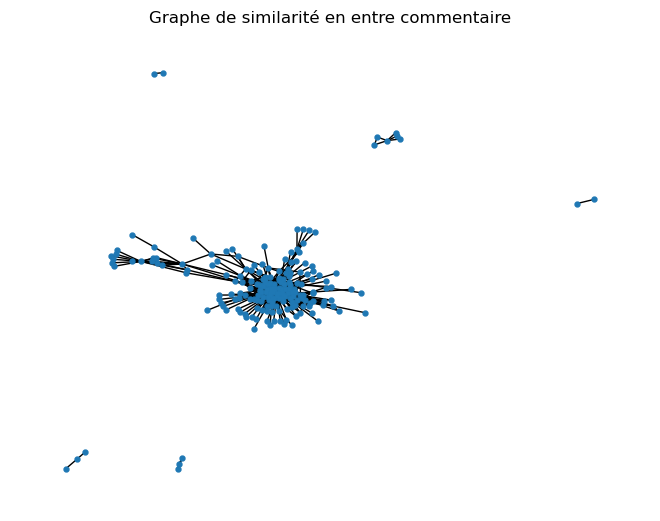

In [248]:
import matplotlib.pyplot as plt
nx.draw(G,node_shape = '.', node_size = 50)
plt.title("Graphe de similarité en entre commentaire")
plt.show()

In [249]:
import numpy as np

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
# Obtenez la liste des arêtes à partir du graphe networkx
edge_list = np.array(G.edges())

# Convertissez la liste des arêtes en tensor PyTorch
edges = torch.tensor(edge_list, dtype=torch.long)

# Transposez le tensor pour obtenir la forme correcte
edges = edges.t().contiguous()
edges

tensor([[  17,   17, 1031,  ...,  985, 1895, 1420],
        [1031, 1567,  214,  ..., 1976, 1976, 1465]])

In [71]:
#Encode y
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df['sentiment'])

LabelEncoder()

In [252]:
y = encoder.transform(df['sentiment'])
y = torch.tensor(y, dtype=torch.long)

In [253]:
y

tensor([1, 1, 1,  ..., 0, 1, 0])

In [254]:
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.nn import GCNConv
edges = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(X.todense(), dtype=torch.float)

# Création d'un objet Data pour chaque graphe
data = Data(x=x, y=y, edge_index=edges)
data_list = [data]

# Création d'un DataLoader pour gérer le chargement des données pendant l'entraînement
loader = DataLoader(data_list, batch_size=32, shuffle=True)
# Étape 2 : Définition du modèle GNN
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return torch.argmax(x, dim=1)

C:\Users\sambe\AppData\Local\Temp\ipykernel_20420\2331019954.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges = torch.tensor(edges, dtype=torch.long)


In [256]:
data.y

tensor([1, 1, 1,  ..., 0, 1, 0])

In [257]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [258]:
# Étape 3 : Entraînement du modèle
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()
torch.set_grad_enabled(True) 

def train(epoch):
    model.train()

    total_loss = total_examples = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data)
        loss = criterion(out.float(), data.y.float())
        loss.requires_grad = True
        loss.backward()
        optimizer.step()

    return loss


@torch.no_grad()
def evale():
    model.eval()
    
    for data in loader:
        data = data.to(device)
        out = model(data)
        acc = accuracy_score(data.y, out)
        auc = roc_auc_score(data.y, out)
    return acc, auc

In [259]:
print(f'Training And Test ')
for epoch in tqdm(range(1, 2)):

    loss = train(epoch)
   
    acc, auc = evale()
    print(f'Loss: {loss:.4f}, accuracy : {acc:.4f}, '
          f'roc auc : {auc:.4f}')

Training And Test 


100%|██████████| 1/1 [00:00<00:00, 11.24it/s]

Loss: 0.7645, accuracy : 0.5170, roc auc : 0.5148
